Описание соревнования

Предскажите, как много звездочек наберет статья, зная только ее текст и время публикации

Необходимо предсказать популярность поста на Хабре по содержанию и времени публикации. Как известно, пользователи Хабра могут добавлять статьи к себе в избранное. Общее количество пользователей, которое это сделали отображается у статьи количеством звездочек. Будем считать, что число звездочек, поставленных статье, наиболее хорошо отражает ее популярность.

Более формально, в качестве метрики популярности статьи будем использовать долю статей за последний месяц, у которых количество звездочек меньше чем у текущей статьи. А точнее, доле числа звездочек можно поставить в соответствие квантили стандартного распределения, таким образом получаем числовую характеристику популярности статьи. Популярность статьи 0 означает, что статья получила ровно столько звездочек, сколько в среднем получают статьи. И соответственно чем больше звездочек получила статья по сравнению со средним, тем выше это число.

Приступим: импортируем необходимые библиотеки и скачаем данные
https://drive.google.com/file/d/1nV2qV9otN3LnVSDqy95hvpJdb6aWtATk/view?usp=sharing

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [2]:
train_df = pd.read_csv('howpop_train.csv')
test_df = pd.read_csv('howpop_test.csv')

train_df.head(1).T

,0
url,https://habrahabr.ru/post/18284/
domain,habrahabr.ru
post_id,18284
published,2008-01-01 18:19:00
author,@Tapac
flow,develop
polling,False
content_len,4305
title,Новогодний подарок блоггерам — WordPress 2.3.2
comments,0


In [3]:
train_df.shape, test_df.shape

((134137, 17), (3990, 9))

Убедимся, что данные отсортированы по признаку published

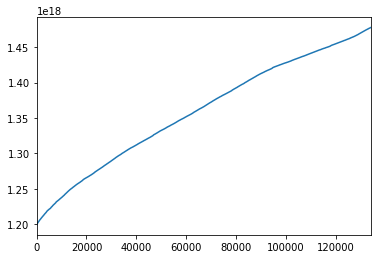

In [4]:
train_df['published'].apply(lambda ts: pd.to_datetime(ts).value).plot()

 Есть ли в train_df признаки, корреляция между которыми больше 0.9? Обратите внимание, именно различные признаки - корреляция признака с самим собой естественно больше 0.9 :)

In [5]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,post_id,polling,content_len,comments,favs,views,votes_plus,votes_minus,views_lognorm,favs_lognorm,comments_lognorm
post_id,1,0.0816283,0.241384,-0.147763,0.0893134,0.132385,-0.187885,-0.235594,-0.0103765,-0.00584468,-0.00160544
polling,0.0816283,1,-0.00333743,0.042605,0.00688216,0.0256602,-0.0335046,0.0271159,-0.00352303,-0.0363849,0.0714173
content_len,0.241384,-0.00333743,1,-0.0235442,0.308194,0.204101,0.0687794,-0.0786861,0.246063,0.356481,0.0731319
comments,-0.147763,0.042605,-0.0235442,1,0.164166,0.290035,0.613961,0.457638,0.349568,0.278942,0.66274
favs,0.0893134,0.00688216,0.308194,0.164166,1,0.634304,0.416241,0.0628765,0.456097,0.587982,0.263239
views,0.132385,0.0256602,0.204101,0.290035,0.634304,1,0.396849,0.128654,0.585105,0.406782,0.326427
votes_plus,-0.187885,-0.0335046,0.0687794,0.613961,0.416241,0.396849,1,0.464168,0.414232,0.449712,0.525081
votes_minus,-0.235594,0.0271159,-0.0786861,0.457638,0.0628765,0.128654,0.464168,1,0.146609,0.0882264,0.355458
views_lognorm,-0.0103765,-0.00352303,0.246063,0.349568,0.456097,0.585105,0.414232,0.146609,1,0.688811,0.54653
favs_lognorm,-0.00584468,-0.0363849,0.356481,0.278942,0.587982,0.406782,0.449712,0.0882264,0.688811,1,0.479476


В каком году было больше всего публикаций? (Рассматриваем train_df)

In [8]:
train_df['published'] = pd.to_datetime(train_df['published'])
train_df['year'] = [i.year for i in train_df['published']]

In [9]:
year_number = train_df.loc[:, 'year'].value_counts()

<BarContainer object of 9 artists>

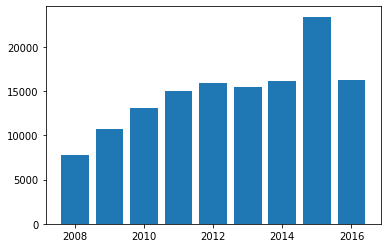

In [10]:
plt.bar(x=year_number.index, height=year_number)

## Разбиение на train/valid
Используем только признаки 'author', 'flow', 'domain' и 'title'

In [11]:
features = ['author', 'flow', 'domain','title']
train_size = int(0.7 * train_df.shape[0])

In [12]:
len(train_df), train_size

(134137, 93895)

In [13]:
X, y = train_df.loc[:, features],  train_df['favs_lognorm']

In [14]:
X_test = test_df.loc[:, features]

In [15]:
X_train, X_valid = X.iloc[:train_size, :], X.iloc[train_size:,:]

y_train, y_valid = y.iloc[:train_size], y.iloc[train_size:]

## Применение TfidfVectorizer